In [59]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')

import seaborn as sns 


In [2]:
df_orders = pd.read_pickle('cleaned_orders.pkl')
df_reviews = pd.read_pickle('cleaned_reviews.pkl')
df_items = pd.read_pickle('cleaned_items.pkl') 
df_customers = pd.read_pickle('cleaned_customers.pkl')
df_payments = pd.read_pickle('cleaned_payments.pkl')
df_products = pd.read_pickle('cleaned_products.pkl')
df_sellers = pd.read_pickle('cleaned_sellers.pkl')
df_geolocation = pd.read_pickle('cleaned_geolocation.pkl')

print(df_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_efficiency            96476 non-null  float64       
 9   is_delayed                     99441 non-null  int32         
dtypes: datetime64[ns](5), float64(1), int32(1), object(3)
memory usage: 7.2+ MB
None


#### 가설1: 배송이 지연된 주문 건 중에서 셀러가 발송 기간을 초과한 경우는 그렇지 않은 경우 대비, 최종 배송 완료일까지의 소요일이 더 길다

- #### 검증 결과: 가설 채택
- 주요 수치: 
    - **발송 준수**: 평균 11.28일 소요
    - **발송 초과**: 평균 19.04일 소요(준수 그룹 대비 7.76일 추가)
- 인사이트: 셀러의 발송 지연은 최종 배송일을 평균 7일 이상 늦추는 영향을 가진다.
- 한계점: 배송사 전용 예정일 데이터 부재로 인해,배송 지연의 가장 큰 단독 원인을 찾는데 한계점이 있었음

In [4]:
#배송 지연 데이터 추출
df_late_delivery = df_orders[
(df_orders['delivery_efficiency'] < 0) &
(df_orders['order_status'] == 'delivered')
].copy()
#아이템 데이터 병합
df_late_delivery = df_late_delivery.merge(df_items[['order_id','shipping_limit_date']], on = 'order_id', how='left')

#처리 지연 
late_process = df_late_delivery[
df_late_delivery['order_delivered_carrier_date'].dt.normalize() > df_late_delivery['shipping_limit_date'].dt.normalize() 
].copy()
print(f"배송 지연 중 처리 지연 비율: {(len(late_process)* 100 / len(df_late_delivery)):.2f}")

배송 지연 중 처리 지연 비율: 23.43


In [138]:
#주문 -아이템
df_orders_items = df_orders.merge(df_items[['order_id','shipping_limit_date']], on = 'order_id')
df_orders_items_f = df_orders_items[(df_orders_items['order_status'] == 'delivered')].copy()

df_orders_items_f['delivery_days'] = (df_orders_items_f['order_delivered_customer_date']-
df_orders_items_f['order_purchase_timestamp']).dt.days


#셀러 지연 여부
df_orders_items_f['is_seller_delayed'] = np.where(
df_orders_items_f['order_delivered_carrier_date'] > df_orders_items_f['shipping_limit_date'], "seller_delayed", "on-time")

seller_delay_days = df_orders_items_f.groupby('is_seller_delayed')['delivery_days'].mean().reset_index()
seller_delay_days['delivery_days'] = seller_delay_days['delivery_days'].round(2)
print('-------셀러 지연 상태별 배송기간-------')
seller_delay_days

-------셀러 지연 상태별 배송기간-------


,is_seller_delayed,delivery_days
0,on-time,11.28
1,seller_delayed,19.05


#### 가설2: 셀러와 고객 주(State)가 다를 때, 동일한 주 내 배송보다 배송 지연율이 높을 것이다

- #### 검증 결과: 가설 채택
- 주요 수치:  
    - **같은 주 배송**: 지연율 4.35%
    - **다른 주 배송**: 지연율 7.56% (1.73배 높음)
    - **평균 지연율 초과 지역**: 같은 주 노선 5곳(총 17개 중), 다른 주 노선 52곳(총 100개 중) 
- 인사이트: 출발지-목적지 노선별 실제 데이터에 기반한 예측도착일 필요

In [143]:
#전체 배송 지연율과 지연 건수 
order_count = df_orders['order_id'].nunique()
total_latedelivery_count = df_orders['is_delayed'].sum()

print(f'전체 배송 지연율: {(total_latedelivery_count / order_count)*100:.2f}%')
print(f'전체 배송 지연 건수: {total_latedelivery_count}')

전체 배송 지연율: 6.57%
전체 배송 지연 건수: 6535


In [189]:
# 데이터 병합
orders_customers = pd.merge(df_orders, df_customers, on = 'customer_id', how = 'left')
orders_items = pd.merge(orders_customers, df_items, on = 'order_id', how = 'left')
orders_base = pd.merge(orders_items, df_sellers, on = 'seller_id', how='left')

# 계산식 추가 
orders_base['total_delivery_time'] = (orders_base['order_delivered_customer_date'] - orders_base['order_purchase_timestamp']).dt.days
orders_base['delay_add_days'] = np.where(orders_base['is_delayed'] == 1,
(orders_base['order_delivered_customer_date'].dt.normalize() - orders_base['order_estimated_delivery_date'].dt.normalize()).dt.days
,0 )
orders_base['is_same_state'] = (orders_base['seller_state']== orders_base['customer_state'])

In [190]:
#집계
hypothesis_test = orders_base.groupby('is_same_state').agg(
        order_count = ('order_id','nunique'),
        delay_count = ('is_delayed', 'sum'),
        delay_rate = ('is_delayed', 'mean'),
        avg_delivery_time =('total_delivery_time', 'mean'),
        delay_add_days = ('delay_add_days', 'mean')
).reset_index()

hypothesis_test['delay_rate'] = (hypothesis_test['delay_rate']*100).round(2)
hypothesis_test['is_same_state'] = hypothesis_test['is_same_state'].map({True:'same_state', False:'other_state'})
print('셀러와 고객의 주가 다를 때 배송 지연율은 7.56%으로 더 크다')
hypothesis_test

셀러와 고객의 주가 다를 때 배송 지연율은 7.56%으로 더 크다


,is_same_state,order_count,delay_count,delay_rate,avg_delivery_time,delay_add_days
0,other_state,64088,5492,7.56,14.584576,0.861261
1,same_state,35600,1773,4.35,7.461205,0.334037


In [186]:
#같은 주(State) 배송도 평균 4.35%를 초과하는 지역 존재
state_analysis = orders_base.groupby(['seller_state', 'customer_state']).agg(
        order_count = ('order_id','nunique'),
        delay_count = ('is_delayed', 'sum'),
        avg_delivery_time =('total_delivery_time', 'mean'),
        delay_add_days = ('delay_add_days', 'mean')
).reset_index()
#지연율계산, 주문건수 30건 이상만 추출 
state_analysis['delay_rate'] =(state_analysis['delay_count'] / state_analysis['order_count'] * 100).round(2)
state_analysis = state_analysis[state_analysis['order_count']>=30]
#같은 주 배송 확인 
same_state = state_analysis[state_analysis['seller_state'] == state_analysis['customer_state']].sort_values(by= 'delay_rate', ascending=False)
same_state_f_count = len(same_state[same_state['delay_rate'] >= 4.35])

print(f'같은 주 노선 중 평균 지연율 이상인 노선 갯수:{same_state_f_count}곳')

같은 주 노선 중 평균 지연율 이상인 노선 갯수:5곳


In [188]:
#다른 주(State) 평균 7.56%를 초과하는 지역 확인
other_state = state_analysis[state_analysis['seller_state'] != state_analysis['customer_state']].sort_values(by='delay_rate', ascending =False)
other_state_f_count= len(other_state[other_state['delay_rate']>=7.56])

print(f'다른 주 노선 중 평균 지연율 이상인 노선 갯수:{other_state_f_count}곳')

다른 주 노선 중 평균 지연율 이상인 노선 갯수:52곳


#### 가설3:배송 지연 주문은 정시  도착 주문보다 평균 리뷰 점수가 낮을 것이다.

- #### 검증 결과: 가설 채택
- 주요 수치:  
    - **정시 도착**: 4.29점
    - **배송 지연**: 2.27점 (2.02점 급락)
        - 지연 1일(3.73점) → 5일(2.19점): 완만한 하락 (일평균 -0.3점)
        - 지연 6일(1.80점) : 급락 및 1점대 진입
        - 지연 8일 이후: 1.7점 이하에서 정체 (회복 불가능)
- 인사이트: 지연 6일차가 임계점이고 지연 5일차 이내 배송 완료를 목표로 삼아야함

In [192]:
#배송 주문 필터링 및 병합
df_delivered_order = df_orders[df_orders['order_status'] == 'delivered'].copy()
df_orders_customers = df_delivered_order.merge(df_customers[['customer_id', 'customer_unique_id']], on ='customer_id', how='left')
df_orders_customers_reviews = df_orders_customers.merge(df_reviews[['order_id', 'review_id', 'review_score']], on = 'order_id', how='left')
#지연 여부
df_orders_customers_reviews['is_delayed'] = np.where(
df_orders_customers_reviews['delivery_efficiency'] < 0, 'delayed', 'on-time'
)
#리뷰 점수 평균 비교
review_comparison = df_orders_customers_reviews.groupby('is_delayed')['review_score'].mean().reset_index()
print('-----지연 상태에 따른 리뷰 점수 비교-----')
review_comparison

-----지연 상태에 따른 리뷰 점수 비교-----


,is_delayed,review_score
0,delayed,2.271025
1,on-time,4.289999


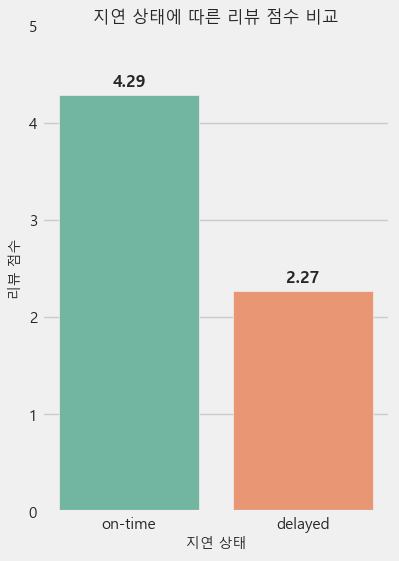

In [200]:
#지연 상태에 따른 리뷰 점수 비교 시각화
#데이터 프레임 생성
df_review_comparison = review_comparison.reset_index().sort_values(by='review_score',ascending =False)

#막대 그래프 그리기
plt.figure(figsize=(4,6))
ax = sns.barplot(
data= df_review_comparison,
x= 'is_delayed',
y='review_score',
palette='Set2',
hue='is_delayed')

#그래프 디테일 설정
plt.title('지연 상태에 따른 리뷰 점수 비교', fontsize = 12, pad=2)
plt.xlabel('지연 상태', fontsize = 10)
plt.ylabel('리뷰 점수', fontsize = 10)
plt.ylim(0, 5)

#막대 위에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center',               
                xytext = (0, 9), 
                textcoords = 'offset points', 
                fontsize=12, fontweight='bold')

plt.show()

In [196]:
#지연 일수에 따른 리뷰 점수 변화 
# 지연된 주문(efficiency < 0)만 추출하여 지연 일수를 양수로 변환
df_only_delayed = df_orders_customers_reviews[df_orders_customers_reviews['delivery_efficiency'] < 0].copy()
df_only_delayed['delay_days'] = df_only_delayed['delivery_efficiency'].abs()

# 지연 일수별 평균 점수 계산
delay_trend = df_only_delayed.groupby('delay_days')['review_score'].mean().reset_index()
print("지연 일수별 리뷰 점수 변화" )
print(delay_trend.head(10))

지연 일수별 리뷰 점수 변화
   delay_days  review_score
0         1.0      3.730255
1         2.0      3.175047
2         3.0      2.683468
3         4.0      2.494279
4         5.0      2.194954
5         6.0      1.808824
6         7.0      1.915789
7         8.0      1.719880
8         9.0      1.666667
9        10.0      1.586538


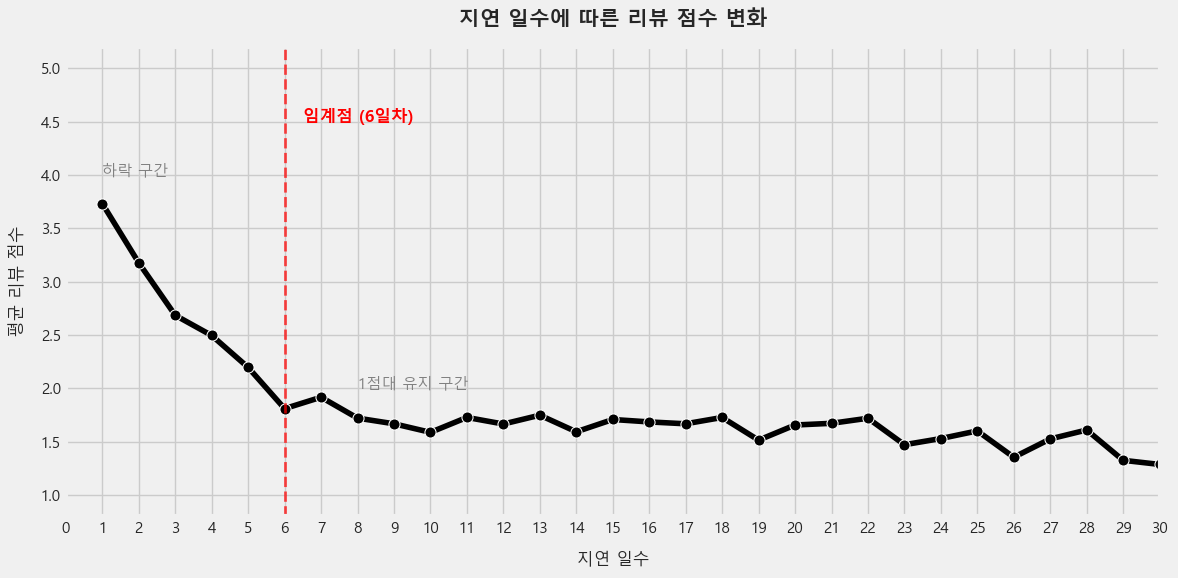

In [197]:
# 지연 일수에 따른 리뷰 점수 변화 시각화
plt.figure(figsize=(12,6))
sns.lineplot(data=delay_trend, x='delay_days', y='review_score', marker='o',
             markersize=8, color= 'black')
#x축값 
plt.xticks(np.arange(0, 31, 1))

#임계선 표시
plt.axvline(x=6, color='red', linestyle='--', linewidth=2, alpha=0.7)

# 텍스트 추가
plt.text(6.5, 4.5, '임계점 (6일차)', color='red', fontweight='bold', fontsize=12)
plt.text(1, 4.0, '하락 구간', fontsize=11, color='gray', style='italic')
plt.text(8, 2.0, '1점대 유지 구간', fontsize=11, color='gray', style='italic')

plt.title('지연 일수에 따른 리뷰 점수 변화', fontsize=15, fontweight='bold', pad=15)
plt.ylabel('평균 리뷰 점수', fontsize=12,labelpad=10)
plt.xlabel('지연 일수', fontsize=12,labelpad=10)
plt.xlim(0,30)
plt.tight_layout()
plt.show()

In [199]:
#배송 지연의 리뷰 점수는 일주일 간 하루에 0.37점씩 하락한다
df_7 = delay_trend[delay_trend['delay_days'].between(1, 7)].sort_values('delay_days')

# 전날 대비 변화량
df_7['daily_drop'] = df_7['review_score'].diff()
df_7['daily_drop'].mean()

-0.30241094839163524

#### 가설4:배송 지연 경험은 재구매 의사결정에 부정적인 허들로 작용하여 재구매율을 낮출 것이다.

- #### 검증 결과: 가설 채택
- 주요 수치:  
    - **배송 지연**: 지연율 2.52%
    - **정시 도착**: 지연율 3.04% (약 0.52%p)
- 한계점: 전체 고객 재구매율이 3%미만으로 낮은 플랫폼 특성상 수치 차이가 크지 않음

In [203]:
#첫 구매 주문 기준 재구매율 비교 
df_orders_customers['order_count'] = df_orders_customers.groupby('customer_unique_id')['order_id'].transform('nunique')
df_orders_customers['re_purchase'] = np.where(df_orders_customers['order_count'] > 1, 1, 0)
#첫 구매 데이터 추출
df_first_orders = df_orders_customers.sort_values('order_purchase_timestamp').groupby('customer_unique_id').first().reset_index()
#첫 구매 지연 여부
df_first_orders['first_is_delayed'] = np.where(df_first_orders['delivery_efficiency'] < 0, 'delayed', 'on-time')
#첫 구매 재구매율
first_repurchase_rate = df_first_orders.groupby('first_is_delayed')['re_purchase'].mean()
print("---첫 구매 지연 후 재구매율---")
first_repurchase_comparison = first_repurchase_rate.reset_index().sort_values(by='re_purchase',ascending=False)
first_repurchase_comparison['re_purchase'] = (first_repurchase_comparison['re_purchase'] * 100).round(2)
first_repurchase_comparison

---첫 구매 지연 후 재구매율---


,first_is_delayed,re_purchase
1,on-time,3.03
0,delayed,2.53


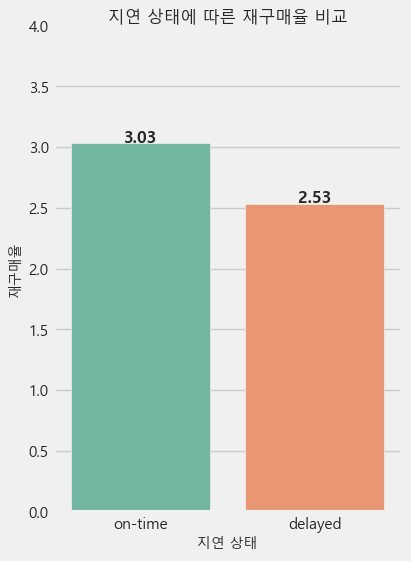

In [205]:
#지연여부에 따른 재구매율 비교 시각화

#막대 그래프 그리기
plt.figure(figsize=(4,6))
ax = sns.barplot(
data= first_repurchase_comparison,
x= 'first_is_delayed',
y='re_purchase',
palette='Set2',
hue='first_is_delayed')

#그래프 디테일 설정
plt.title('지연 상태에 따른 재구매율 비교', fontsize = 12, pad=2)
plt.xlabel('지연 상태', fontsize = 10)
plt.ylabel('재구매율', fontsize = 10)
plt.ylim(0,4)

#막대 위에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center',               
                xytext = (0, 4), 
                textcoords = 'offset points', 
                fontsize=12, fontweight='bold')

plt.show()

#### 가설5: 배송 지연을 경험한 고객은 재구매 주기가 대조군 대비 더 늦을 것이다.

- #### 검증 결과: 가설 기각
- 주요 수치:  
    - **평균 재구매 간격:** 지연 그룹(57.7일) < 정시 그룹(82.2일)
    - **중앙값 재구매 간격:** 지연 그룹(16.5일) < 정시 그룹(29일)
- 인사이트: 불편을 감수하며 재구매를 한 이 그룹은 충성 고객으로 태블로에서 추출 후 지속 관찰 필요

In [18]:
# 고객과 구매 시간별 정렬
df_sorted = df_orders_customers.sort_values(['customer_unique_id', 'order_purchase_timestamp'])

# 고객별 주문 순서
df_sorted['order_rank'] = df_sorted.groupby('customer_unique_id').cumcount() + 1

# 첫 번째와 두 번째 주문 필터링
df_recency = df_sorted[df_sorted['order_rank'].isin([1, 2])].copy()
# 다음 주문 날짜 열 생성
df_recency['next_order_date'] = df_recency.groupby('customer_unique_id')['order_purchase_timestamp'].shift(-1)

# 첫 번째 주문 필터링 후, 구매 간격 계산
df_first = df_recency[df_recency['order_rank'] == 1].copy()
df_first['purchase_interval'] = (df_first['next_order_date'] - df_first['order_purchase_timestamp']).dt.days
df_first['is_delayed'] = np.where(df_first['delivery_efficiency'] < 0, 'delayed', 'on-time')

In [207]:
#첫 번째 주문 수치 확인
print(f"고객별 첫번째 주문:{len(df_first)}")
print("------ 첫번째 구매 후 지연 경험자 수 ------")
df_first_orders['first_is_delayed'].value_counts()

고객별 첫번째 주문:93358
------ 첫번째 구매 후 지연 경험자 수 ------


on-time    87002
delayed     6356
Name: first_is_delayed, dtype: int64

In [208]:
# 지연 여부별 평균 간격 비교
recency_result = df_first.groupby('is_delayed')['purchase_interval'].mean().reset_index()

print("------ 그룹별 평균 재구매 간격(일) ------")
recency_result

------ 그룹별 평균 재구매 간격(일) ------


,is_delayed,purchase_interval
0,delayed,57.722222
1,on-time,82.264115


In [209]:
# 배송 상태별 재구매 건수, 재구매 주기 평균값과 중앙값
df_first.dropna(subset =['purchase_interval']).groupby('is_delayed')['purchase_interval'].agg(['mean','count','median'])

,mean,count,median
is_delayed,,,
delayed,57.722222,162,16.5
on-time,82.264115,2639,29.0
